# BERT Transformer

In [23]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from pandas import read_parquet, DataFrame, Series, concat, merge, to_numeric
from data import file
from tqdm import tqdm
from preprocessing.categorical import binarizer
import numpy as np
from datetime import datetime
from reporting.evaluation import plot_confusion_matrix
import json

In [2]:
# apply progress bar on pandas operations
tqdm.pandas()

In [3]:
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

In [4]:
data_train = read_parquet(file.news_articles_cleaned_train)
data_test = read_parquet(file.news_articles_cleaned_test)
data_val = read_parquet(file.news_articles_cleaned_val)

In [5]:
print("train size:", data_train.shape, "categories:", len(data_train.label.unique()))
print("test size :", data_test.shape, "categories:", len(data_test.label.unique()))
print("val size  :", data_val.shape, "categories:", len(data_val.label.unique()))

train size: (7216, 9) categories: 9
test size : (2062, 9) categories: 9
val size  : (1031, 9) categories: 9


In [6]:
MAXLEN = 192

def tokenize(review):

  encoded = tokenizer.encode_plus(
      text=review,
      add_special_tokens=True,     # Add `[CLS]` and `[SEP]`
      max_length=MAXLEN,           # Max length to truncate/pad
      padding='max_length',        # Pad sentence to max length
      return_attention_mask=False, # attention mask not needed for our task
      return_token_type_ids=False,
      truncation=True)
  return encoded['input_ids']

In [7]:
data_hf_tokenized_train = concat([data_train, data_train.text_original.progress_map(tokenize).rename('hf_tokenized')], axis=1)
data_hf_tokenized_train.to_parquet(path=file.news_articles_hf_tokenized_train)

100%|██████████| 7216/7216 [00:51<00:00, 141.30it/s]


In [8]:
data_hf_tokenized_test = concat([data_test, data_test.text_original.progress_map(tokenize).rename('hf_tokenized')], axis=1)
data_hf_tokenized_test.to_parquet(path=file.news_articles_hf_tokenized_test)

100%|██████████| 2062/2062 [00:14<00:00, 139.08it/s]


In [9]:
data_hf_tokenized_val = concat([data_val, data_val.text_original.progress_map(tokenize).rename('hf_tokenized')], axis=1)
data_hf_tokenized_val.to_parquet(path=file.news_articles_hf_tokenized_val)

100%|██████████| 1031/1031 [00:07<00:00, 141.50it/s]


In [10]:
hf_data_train = read_parquet(file.news_articles_hf_tokenized_train)
hf_data_test = read_parquet(file.news_articles_hf_tokenized_test)
hf_data_val = read_parquet(file.news_articles_hf_tokenized_val)

print("train size:", hf_data_train.shape, "categories:", len(hf_data_train.label.unique()))
print("test size :", hf_data_test.shape, "categories:", len(hf_data_test.label.unique()))
print("val size  :", hf_data_val.shape, "categories:", len(hf_data_val.label.unique()))

train size: (7216, 10) categories: 9
test size : (2062, 10) categories: 9
val size  : (1031, 10) categories: 9


In [11]:
label_binarizer=binarizer(hf_data_train.label)
label_bin_train = label_binarizer.transform(hf_data_train.label)
label_bin_test = label_binarizer.transform(hf_data_test.label)

print("train label size:", label_bin_train.shape, "categories:", len(hf_data_train.label.unique()))
print("test label size :", label_bin_test.shape, "categories:", len(hf_data_test.label.unique()))

train label size: (7216, 9) categories: 9
test label size : (2062, 9) categories: 9


In [12]:
BATCH_SIZE = 16
EPOCHS = 8
LEARNING_RATE = 1e-5

train_dataset = (tf.data.Dataset.from_tensor_slices((hf_data_train.hf_tokenized.map(lambda x:x.tolist()).tolist(), label_bin_train))
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

test_dataset = (tf.data.Dataset.from_tensor_slices((hf_data_test.hf_tokenized.map(lambda x:x.tolist()).tolist(), label_bin_test))
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))


2021-11-23 06:19:01.811177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 06:19:01.837119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 06:19:01.837683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 06:19:01.838779: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [13]:
def build_model(output_classes, max_len=MAXLEN):
    """ add binary classification to pretrained model
    """

    input_word_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_word_ids"
    )

    bert_model = TFBertModel.from_pretrained("bert-base-german-cased")
    encoder_outputs = bert_model(input_word_ids)

    pooler_output = encoder_outputs[1]
    cls_embedding = pooler_output

    stack = tf.keras.layers.Dense(output_classes)(cls_embedding)
    output = tf.keras.layers.Activation('softmax')(stack)

    ##########################
    ## YOUR CODE HERE END ##
    ##########################

    model = tf.keras.models.Model(inputs=input_word_ids, outputs=output)
    
    return model


In [14]:
model = build_model(len(data_train.label.unique()), max_len=MAXLEN)
model.summary()

Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 109081344 
_________________________________________________________________
dense (Dense)                (None, 9)                 6921      
_________________________________________________________________
activation (Activation)      (None, 9)                 0         
Total params: 109,088,265
Trainable params: 109,088,265
Non-trainable params: 0
_________________________________________________________________


In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = "binary_crossentropy"

model.compile(optimizer, loss=loss, metrics=["accuracy"])

In [16]:
hist = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=int(np.floor((len(hf_data_train) / BATCH_SIZE))),
    validation_data=test_dataset,
    verbose=1,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=1, restore_best_weights=True),
               tf.keras.callbacks.TensorBoard(f'logs/{datetime.now()}')
               ],
)

2021-11-23 06:19:12.903533: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-23 06:19:12.903575: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-23 06:19:12.904423: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs


2021-11-23 06:19:13.110590: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-23 06:19:13.110754: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/8


2021-11-23 06:19:22.646578: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


  1/451 [..............................] - ETA: 1:36:42 - loss: 0.6437 - accuracy: 0.1250

2021-11-23 06:19:26.494188: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-23 06:19:26.494222: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/451 [..............................] - ETA: 8:43 - loss: 0.6469 - accuracy: 0.0938   

2021-11-23 06:19:27.327841: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-23 06:19:27.330029: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-11-23 06:19:27.483913: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 3002 callback api events and 2999 activity events. 
2021-11-23 06:19:27.549813: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-23 06:19:27.659812: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/2021-11-23 06:19:12.901142/train/plugins/profile/2021_11_23_06_19_27

2021-11-23 06:19:27.717805: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/2021-11-23 06:19:12.901142/train/plugins/profile/2021_11_23_06_19_27/frankfurt-tf-26-cpu-2-gpu-1.trace.json.gz
2021-11-23 06:19:27.837260: I tensorflow/core/profi

451/451 [==============================] - 350s 749ms/step - loss: 0.1469 - accuracy: 0.7636 - val_loss: 0.0797 - val_accuracy: 0.8691
Epoch 2/8
451/451 [==============================] - 337s 748ms/step - loss: 0.0596 - accuracy: 0.9130 - val_loss: 0.0775 - val_accuracy: 0.8744
Epoch 3/8
451/451 [==============================] - 337s 748ms/step - loss: 0.0347 - accuracy: 0.9548 - val_loss: 0.0782 - val_accuracy: 0.8851
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


## Evaluation

In [20]:
count = 100
sample = data_hf_tokenized_val[0:count]
expected = sample.label

predicted = label_binarizer.inverse_transform(model.predict(sample.hf_tokenized.tolist()))

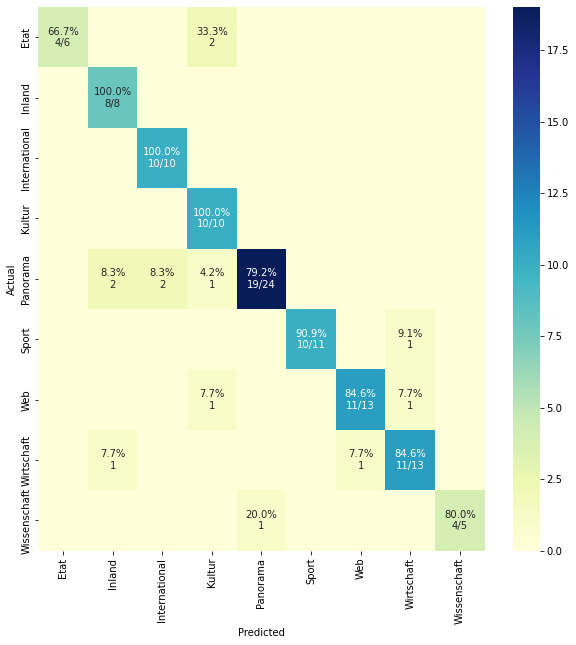

In [21]:
plot_confusion_matrix(expected, predicted)

In [25]:
reporting_data = {
    "expected": expected.tolist(),
    "predicted": predicted.tolist(),
}
with open(file.reporting_data_report_bert, 'w') as f:
    json.dump(reporting_data, f)